# 🔎 FHIR Difference: Quality Inspection 🔎

Evaluating whether a generated/predicted Fhir resources is accurate is difficult due to the verbose nature of FHIR.
The note_to_fhir.evaluation module makes this easier with:
- A <b>FhirScore</b> object that tracks the number of changes/similarities w.r.t the ground truth throughout the whole depth of the fhir resource 
- A <b>FhirDiff</b> (tree) object contains all relevant details of the FHIR comparison, including the FhirScore at each level. 
- Visualizations for the above FhirDiff and FhirScore

In [32]:
from src.note_to_fhir.evaluation.datamodels import FhirScore, FhirDiff
import os
from src.note_to_fhir.evaluation.datamodels import FhirDiff
from src.note_to_fhir.evaluation.utils import get_diff, diff_to_list, diff_to_dataframe, compare_leaf, get_resource_details, get_resource_class, diff_to_dataframe
from src.note_to_fhir.evaluation.visuals import show_diff
from datasets import load_dataset
import json

In [33]:
testset = load_dataset("healthsage/example_fhir_output")

In [34]:
fhir_true = json.loads(testset["train"]["fhir_true"][0])
fhir_pred = json.loads(testset["train"]["note_to_fhir"][0])

### 🌲 FHIR JSON trees
A dictionary representation of FHIR has a tree structure. On the root level, we find the dataset, which consists of bundles. Each bundle has entries with resources that can contain nested resources of an arbitrary depth. E.g.:

- Dataset
  - Bundle
    - BundleEntry
       - Resource (Encounter, Condition, Patient, etc.)
           - Resource element
                - Nested Resource
                    - Nested Resource
    - Bundle Entry
        - ...
  - Bundle
                

The note_to_fhir.evaluation module follows this tree structure.

### 🍀 Evaluating leaf nodes

The most elemental comparison that can be done is that of the leaf nodes. The FhirScore object can represent the difference between two leaf nodes

### 🚦The FhirScore Object

In [35]:
score = FhirScore()
score

FhirScore(n_leaves=0, n_additions=0, n_deletions=0, n_modifications=0, n_matches=0, is_valid=None, accuracy=0.0, precision=0.0, recall=0.0)

#### 🍀 Base example: comparing a and b with compare leaf 

In [36]:
print(compare_leaf.__doc__)

Compares two leaf nodes of a FHIR structure

    Args:
        element_true (any): The ground truth fhir element
        element_pred (any): The predicted fhir element

    Returns:
        FhirScore: object containing score for the leaf node.
    


In [37]:
compare_leaf("a", "a")

FhirScore(n_leaves=1, n_additions=0, n_deletions=0, n_modifications=0, n_matches=1, is_valid=None, accuracy=1.0, precision=1.0, recall=1.0)

In [38]:
compare_leaf("a", "b")

FhirScore(n_leaves=1, n_additions=0, n_deletions=0, n_modifications=1, n_matches=0, is_valid=None, accuracy=0.0, precision=0.0, recall=0.0)

In [39]:
compare_leaf("a", None)

FhirScore(n_leaves=1, n_additions=0, n_deletions=1, n_modifications=0, n_matches=0, is_valid=None, accuracy=0.0, precision=0.0, recall=0.0)

In [40]:
compare_leaf(None, "a")

FhirScore(n_leaves=1, n_additions=1, n_deletions=0, n_modifications=0, n_matches=0, is_valid=None, accuracy=0.0, precision=0.0, recall=0.0)

### 🧮 You can add / sum FhirScores together
The score of a given element in the Fhir Tree is essentially the sum of its parts. Therefore, you can add FhirScores.

In [41]:
score_a = compare_leaf("a", "a")
score_b = compare_leaf("a", "b")

In [42]:
score_a + score_b

FhirScore(n_leaves=2, n_additions=0, n_deletions=0, n_modifications=1, n_matches=1, is_valid=None, accuracy=0.5, precision=0.5, recall=0.5)

In [43]:
sum([compare_leaf("a", "a"), compare_leaf("a", "b")])

FhirScore(n_leaves=2, n_additions=0, n_deletions=0, n_modifications=1, n_matches=1, is_valid=None, accuracy=0.5, precision=0.5, recall=0.5)

In [44]:
sum([compare_leaf("a", "a")])

FhirScore(n_leaves=1, n_additions=0, n_deletions=0, n_modifications=0, n_matches=1, is_valid=None, accuracy=1.0, precision=1.0, recall=1.0)

### ↔️ The FhirDiff object

Sample data

 💬 Example ground truth Encounter

In [45]:
encounter_true, encounter_pred  = fhir_true['entry'][0], fhir_pred['entry'][0]

In [46]:
encounter_true

{'resource': {'resourceType': 'Encounter',
  'id': '1',
  'status': 'finished',
  'class': {'system': 'http://terminology.hl7.org/CodeSystem/v3-ActCode',
   'code': 'AMB'},
  'type': None,
  'subject': {'reference': 'Patient/1', 'display': 'Mr. Chase Olson'},
  'participant': [{'type': [{'coding': [{'system': 'http://terminology.hl7.org/CodeSystem/v3-ParticipationType',
        'code': 'PPRF',
        'display': 'primary performer'}],
      'text': 'primary performer'}],
    'period': {'start': '2023-01-17T21:42:36+01:00',
     'end': '2023-01-17T21:57:36+01:00'},
    'individual': {'reference': 'Practitioner/1',
     'display': 'Dr. Jude Reynolds'}}],
  'period': {'start': '2023-01-17T21:42:36+01:00',
   'end': '2023-01-17T21:57:36+01:00'},
  'reasonCode': None,
  'serviceProvider': None}}

In [47]:
encounter_pred

{'resource': {'resourceType': 'Encounter',
  'id': '1',
  'status': 'unknown',
  'class': {'system': 'http://terminology.hl7.org/CodeSystem/v3-ActCode',
   'code': 'AMB'},
  'type': None,
  'subject': {'reference': 'Patient/1', 'display': 'Mr. Chase Olson'},
  'participant': [{'type': None,
    'period': {'start': '2023-01-17T21:42:00+01:00',
     'end': '2023-01-17T21:57:00+01:00'},
    'individual': {'reference': 'Practitioner/1',
     'display': 'Dr. Jude Reynolds'}}],
  'period': None,
  'reasonCode': None,
  'serviceProvider': None}}

In [48]:
print(get_diff.__doc__)

Calculate the FhirDiff object for comparing two FHIR resources.

    Args:
        fhir_true (dict): The ground truth FHIR resource
        fhir_pred (dict): The predicted/generated FHIR resource
        resource_type (str): The resource type

    Returns:
        FhirDiff: Tree object containing the fhir to be compared.
    


In [49]:
diff = get_diff(encounter_true, encounter_pred, resource_type="BundleEntry")

In [50]:
encounter_true

{'resource': {'resourceType': 'Encounter',
  'id': '1',
  'status': 'finished',
  'class': {'system': 'http://terminology.hl7.org/CodeSystem/v3-ActCode',
   'code': 'AMB'},
  'type': None,
  'subject': {'reference': 'Patient/1', 'display': 'Mr. Chase Olson'},
  'participant': [{'type': [{'coding': [{'system': 'http://terminology.hl7.org/CodeSystem/v3-ParticipationType',
        'code': 'PPRF',
        'display': 'primary performer'}],
      'text': 'primary performer'}],
    'period': {'start': '2023-01-17T21:42:36+01:00',
     'end': '2023-01-17T21:57:36+01:00'},
    'individual': {'reference': 'Practitioner/1',
     'display': 'Dr. Jude Reynolds'}}],
  'period': {'start': '2023-01-17T21:42:36+01:00',
   'end': '2023-01-17T21:57:36+01:00'},
  'reasonCode': None,
  'serviceProvider': None}}

In [51]:
diff.score

FhirScore(n_leaves=16, n_additions=0, n_deletions=6, n_modifications=3, n_matches=7, is_valid=None, accuracy=0.4375, precision=0.7, recall=0.4375)

### The score shows:
- There are 16 leaf elements in both resources   
-----> 7 were identical   
-----> 6 are missing in the prediction (n_deletions). This impacts recall score   
-----> 3 are changed (n_modifications). This impacts accuracy and precision   
-----> 0 are added (n_additions), meaning there are no hallucinations   

### We can navigate the Diff tree and see the score at each node. For instance, the "participant field"

In [52]:
diff.children['resource'].children['participant'][0].score

FhirScore(n_leaves=8, n_additions=0, n_deletions=4, n_modifications=2, n_matches=2, is_valid=None, accuracy=0.25, precision=0.5, recall=0.25)

# 📊 Visualization

In [53]:
print(show_diff.__doc__)

Produces a treemap visualization of the FhirDiff object in plotly

    Args:
        diff (FhirDiff): Processed FhirDiff object with scores calculated.
    


In [54]:
show_diff(diff)

### The visualization clearly shows where the differences are:

- Red are 0% accuracy leaves
- Blue are 100% accuracy leaves
- Colors in between represent the accuracy scale

### Learning from this example:

- The period in which the participant was present in the encounter differed by 36 seconds. A neglible difference.
- The Participant type was not predicted, resulting in 4 "missing" nodes
- The Period of the Ecnounter itself was not predicted, altough it was identical to the period of the participant
- The predicted status was unknown where the actual status was finished

### Visualization of the entire Bundle

In [55]:
diff = get_diff(fhir_true, fhir_pred, resource_type="Bundle")

In [56]:
show_diff(diff)

### 📊 Visualizing Diffs in bar charts

In [57]:
df = diff_to_dataframe(diff)

In [58]:
df.head()

,resource_type,entry_nr,key,label,n_leaves,n_matches,n_additions,n_deletions,n_modifications,accuracy,precision,recall,score
0,Bundle,,Bundle,Bundle,49,35,1,10,3,0.714286,0.897436,0.729167,n_leaves=49 n_additions=1 n_deletions=10 n_mod...
1,string,,id,id,1,1,0,0,0,1.000000,1.000000,1.000000,n_leaves=1 n_additions=0 n_deletions=0 n_modif...
2,BundleEntry,0,entry,entry.0,16,7,0,6,3,0.437500,0.700000,0.437500,n_leaves=16 n_additions=0 n_deletions=6 n_modi...
3,Encounter,,resource,Encounter,16,7,0,6,3,0.437500,0.700000,0.437500,n_leaves=16 n_additions=0 n_deletions=6 n_modi...
4,string,,id,id,1,1,0,0,0,1.000000,1.000000,1.000000,n_leaves=1 n_additions=0 n_deletions=0 n_modif...


In [59]:
scores_per_type = df[['resource_type','score']].groupby('resource_type').sum()

In [60]:
scores_per_type['accuracy'] = scores_per_type['score'].apply(lambda x: x.accuracy)

In [61]:
scores_per_type

,score,accuracy
resource_type,,
Address,n_leaves=5 n_additions=0 n_deletions=0 n_modif...,1.000000
AllergyIntolerance,n_leaves=12 n_additions=1 n_deletions=4 n_modi...,0.583333
Bundle,n_leaves=49 n_additions=1 n_deletions=10 n_mod...,0.714286
BundleEntry,n_leaves=47 n_additions=1 n_deletions=10 n_mod...,0.702128
CodeableConcept,n_leaves=16 n_additions=0 n_deletions=8 n_modi...,0.500000
Coding,n_leaves=15 n_additions=0 n_deletions=6 n_modi...,0.600000
ContactPoint,n_leaves=3 n_additions=0 n_deletions=0 n_modif...,1.000000
Encounter,n_leaves=16 n_additions=0 n_deletions=6 n_modi...,0.437500
EncounterParticipant,n_leaves=8 n_additions=0 n_deletions=4 n_modif...,0.250000


<Axes: xlabel='resource_type'>

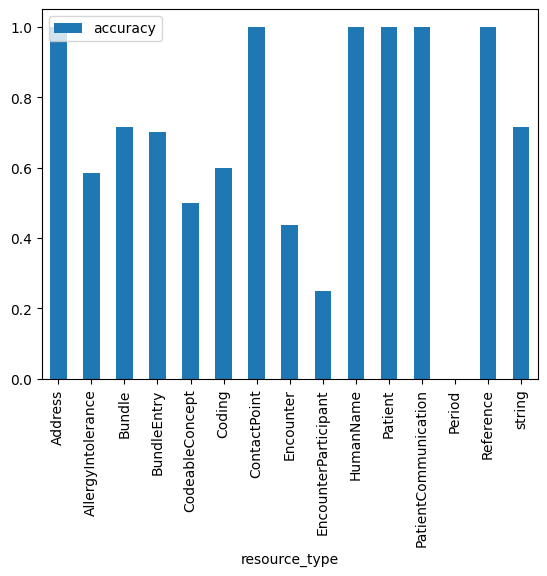

In [62]:
scores_per_type.plot(kind='bar')

### Future developments:
- Mapping corresponding arrays that are not in identical order
- Weighted metrics, scores are now weighted by n_leaves, but could also be weighted by resource element, bundle
- FHIR validation